In [31]:
import re
import gc
import os
import time
import datetime
import collections
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from shutil import copyfile
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import keras
from keras import optimizers
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dense, Input, Dropout, Flatten, Activation, Conv1D, LSTM
from keras.layers.advanced_activations import PReLU
from keras.initializers import Constant
from keras.initializers import he_normal, he_uniform
from keras.optimizers import Adam, Nadam
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler

In [32]:
# seems to reduce the chance of gpu errors, also doesn't blindly allocate all vram 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [33]:
def log_specgram(audio, sample_rate=16000, eps=1e-10):
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=240,
                                    noverlap=120,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def list_wavs_fname(dirpath, ext='wav'):
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+\\(\w+)\\\w+\.wav$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+\\(\w+\.wav)$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, num):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - 16000)
        yield samples[beg: beg + 16000]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))

In [34]:
L = 16000
legal_labels = 'yes no up down left right on off stop go silence unknown'.split()

#src folders
root_path = r'.\\data'
out_path = r'.'
model_path = r'.'
train_data_path = os.path.join(root_path, 'input', 'train', 'audio')
test_data_path = os.path.join(root_path, 'input', 'test', 'audio')

In [35]:
def fraction(label):
    if label == 'backward':
        return 6
    if label in ['four', 'five', 'nine', 'follow', 'forward']:
        return 7
    if label in ['one', 'seven', 'learn']:
        return 8
    if label in ['over', 'cat', 'six', 'house', 'dog']:
        return 9
    return 10

In [36]:
labels, fnames = list_wavs_fname(train_data_path)
np.random.seed(0)

new_sample_rate = 16000
y = []
x = []
x_val = []
y_val = []
t0 = datetime.datetime.now()
i = 0

for label, fname in zip(labels, fnames):
    i+=1
    if label not in legal_labels and label != '_background_noise_' and np.random.randint(5) > 0:
        continue
    if i%10 == 0:
        delta = datetime.datetime.now() - t0
        clear_output(wait=True)
        print('%.2f%% %.1f seconds left' % (i*100/len(labels), delta.total_seconds()*(len(labels)/i-1)))
    sample_rate, samples = wavfile.read(os.path.join(train_data_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples, len(samples)//20000 + 1)
    else: n_samples = [samples]        
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        if False: 
        #if fname[0] == '0' or fname[0] == '1' or label == '_background_noise_' and np.random.randint(5) == 0:
            y_val.append(label)
            x_val.append(specgram)
        else:
            y.append(label)
            x.append(specgram)


t0 = datetime.datetime.now()
labels, fnames = list_wavs_fname('pseudo')
i = 0
for label, fname in zip(labels, fnames):
    i+=1
    if i%10 == 0:
        delta = datetime.datetime.now() - t0
        clear_output(wait=True)
        print('pseudo\n%.2f%% %.1f seconds left' % (i*100/len(labels), delta.total_seconds()*(len(labels)/i-1)))
    sample_rate, samples = wavfile.read(os.path.join('pseudo', label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples, len(samples)//20000 + 1)
    else: n_samples = [samples]        
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y.append(label)
        x.append(specgram)
        

x = np.array(x)
x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std
y = label_transform(y)
label_index = y.columns.values
y = y.values
y = np.array(y)

# x_val = np.array(x_val)
# x_val = (x_val - x_mean) / x_std
# y_val = label_transform(y_val)
# y_val = y_val.values
# y_val = np.array(y_val)

clear_output()

In [37]:
collections.Counter(label_index[np.argmax(y, axis=1)])

Counter({'unknown': 8103,
         'down': 5269,
         'go': 4757,
         'left': 5691,
         'no': 4652,
         'off': 5526,
         'on': 5364,
         'right': 5939,
         'stop': 6480,
         'up': 4822,
         'yes': 6693,
         'silence': 9416})

In [38]:
from keras.layers.advanced_activations import ELU
from keras.layers import Bidirectional, GaussianNoise

def big_boy():
    i = Input(shape=(132, 121))
    x = GaussianNoise(0.2)(i)
    
    x = Conv1D(filters=256, kernel_size=6, strides=2, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(filters=512, kernel_size=6, strides=2, kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform())(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
        
    x = Bidirectional(LSTM(512, unroll=True,
             dropout=0.4, recurrent_dropout=0.5,
             kernel_regularizer=l2(1e-3), recurrent_regularizer=l2(1e-5), bias_regularizer=l2(1e-5)))(x)
     
    x = Dropout(0.5)(x)

    x = Dense(units=512, kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform())(x)
    x = ELU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    o = Dense(units=12, activation='softmax')(x)
    
    return Model(inputs=i, outputs=o)

model = big_boy()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 132, 121)          0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 132, 121)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 64, 256)           186112    
_________________________________________________________________
elu_7 (ELU)                  (None, 64, 256)           0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 64, 256)           1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 30, 512)           7869

In [39]:
opt = Nadam(lr=.01, epsilon=1e-4)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

def step_scheduler(epoch, lr):
    if epoch < 2:
        return lr/2
    return 2e-3 - 1e-5*epoch


history = model.fit(x, y,
                    batch_size=256, epochs=200,
                    #validation_data=(x_val, y_val),
                    verbose=2,
                    callbacks=[LearningRateScheduler(step_scheduler, verbose=0)])

Epoch 1/200
 - 70s - loss: 3.3495 - accuracy: 0.6779
Epoch 2/200
 - 63s - loss: 1.2765 - accuracy: 0.8810
Epoch 3/200
 - 62s - loss: 1.0616 - accuracy: 0.9128
Epoch 4/200
 - 62s - loss: 1.0235 - accuracy: 0.9221
Epoch 5/200
 - 62s - loss: 1.2366 - accuracy: 0.9166
Epoch 6/200
 - 63s - loss: 0.9644 - accuracy: 0.9303
Epoch 7/200
 - 61s - loss: 0.9707 - accuracy: 0.9314
Epoch 8/200
 - 61s - loss: 0.8790 - accuracy: 0.9400
Epoch 9/200
 - 61s - loss: 0.7854 - accuracy: 0.9438
Epoch 10/200
 - 61s - loss: 0.8443 - accuracy: 0.9431
Epoch 11/200
 - 61s - loss: 0.8069 - accuracy: 0.9460
Epoch 12/200
 - 61s - loss: 0.7928 - accuracy: 0.9475
Epoch 13/200
 - 61s - loss: 0.8862 - accuracy: 0.9467
Epoch 14/200
 - 61s - loss: 0.8462 - accuracy: 0.9469
Epoch 15/200
 - 61s - loss: 0.7888 - accuracy: 0.9499
Epoch 16/200
 - 61s - loss: 0.7975 - accuracy: 0.9502
Epoch 17/200
 - 61s - loss: 0.7734 - accuracy: 0.9518
Epoch 18/200
 - 61s - loss: 0.8371 - accuracy: 0.9504
Epoch 19/200
 - 61s - loss: 0.8485 - 

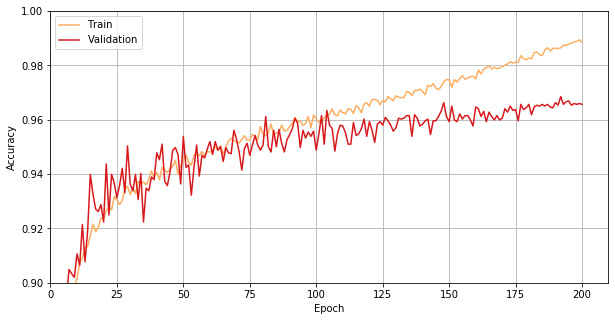

In [10]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.9, 1)
plt.xlim(0)
plt.grid()
plt.show()

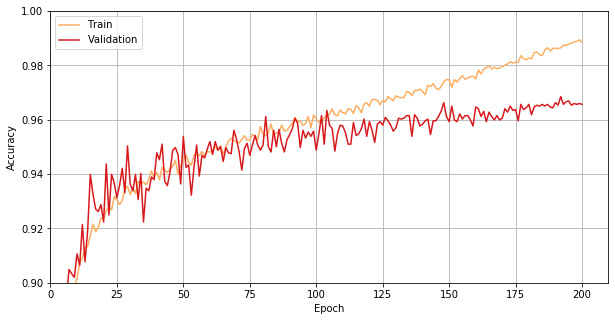

In [11]:
f = plt.figure(figsize=(10,5))

x = range(1, 201)
y1 = history.history['accuracy']# + history2.history['accuracy']
y2 = history.history['val_accuracy']# + history2.history['val_accuracy']

#xs = np.linspace(1, 400, 1000)
#y1s = UnivariateSpline(x, y1, s=0.002)(xs)
#y2s = UnivariateSpline(x, y2, s=0.03)(xs)

#plt.plot(xs, y1s, color='#377eb8', linewidth=2.0)
#plt.plot(xs, y2s, color='#4daf4a', linewidth=2.0)
#plt.plot(x, acc, color='#abd9e9')
#plt.plot(x, val, color='#2c7bb6')
plt.plot(x, y1, color='#fdae61')
plt.plot(x, y2, color='#d7191c')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.ylim(.9, 1)
plt.xlim(0)
plt.grid()
plt.show()

In [25]:
collections.Counter(label_index[np.argmax(y, axis=1)])

Counter({'unknown': 4072,
         'down': 2359,
         'go': 2372,
         'left': 2353,
         'no': 2375,
         'off': 2357,
         'on': 2367,
         'right': 2367,
         'stop': 2380,
         'up': 2375,
         'yes': 2377,
         'silence': 435})

In [41]:
def test_data_generator(batch):
    fpaths = glob(os.path.join(test_data_path, '*wav'))
    i = 0
    for path in fpaths:
        if i == 0:
            imgs = []
            fnames = []
        i += 1
        rate, samples = wavfile.read(path)
        samples = pad_audio(samples)
        resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        imgs.append(specgram)
        fnames.append(path.split('\\')[-1])
        if i == batch:
            i = 0
            yield fnames, (np.array(imgs) - x_mean) / x_std
    yield fnames, (np.array(imgs) - x_mean) / x_std

In [42]:
gc.collect()

index = []
results = []
t0 = datetime.datetime.now()
i = 1
b = 128
pnames = []
plabels = []

for fnames, imgs in test_data_generator(b):
#     pred = np.sqrt(models[9].predict(imgs))
#     for u in range(9):
#         pred = pred + np.sqrt(models[u].predict(imgs))
    pred = model.predict(imgs)
    m = np.max(pred, axis=1)
    pred = np.argmax(pred, axis=1)
    pred = [label_index[p] for p in pred]
    index.extend(fnames)
    results.extend(pred)
    pnames.extend(np.asarray(fnames)[m>.99999].tolist())
    plabels.extend(np.asarray(pred)[m>.99999].tolist())
    delta = datetime.datetime.now() - t0
    clear_output(wait=True)
    print('%.2f%% %.1f seconds left' % (b*i/1585.38, delta.total_seconds()*(158538/b/i-1)))
    i+=1
clear_output()

In [15]:
len(plabels)

0

In [13]:
os.getcwd()

'C:\\Users\\01124585\\Desktop\\Projects\\TF_Speech'

In [29]:
for l in set(plabels):
    if l != 'unknown':
        os.mkdir(os.path.join('pseudo', l))

In [30]:
for label, name in zip(plabels, pnames):
    if label != 'unknown':
        copyfile(os.path.join(test_data_path, name), os.path.join('pseudo', label, name))

In [12]:
collections.Counter(plabels) #99.9

Counter({'no': 4474,
         'unknown': 52059,
         'silence': 14564,
         'go': 3952,
         'off': 4337,
         'yes': 4900,
         'stop': 4928,
         'down': 4152,
         'on': 4681,
         'up': 3726,
         'left': 4413,
         'right': 4625})

In [133]:
collections.Counter(plabels) #99.99

Counter({'no': 4058,
         'unknown': 39429,
         'go': 3714,
         'off': 3870,
         'stop': 4833,
         'down': 3625,
         'silence': 13523,
         'yes': 4738,
         'on': 4609,
         'up': 3597,
         'left': 4463,
         'right': 4542})

In [27]:
collections.Counter(plabels) #99.999

Counter({'no': 2277,
         'unknown': 27981,
         'go': 2385,
         'off': 3169,
         'stop': 4100,
         'down': 2910,
         'silence': 8981,
         'yes': 4316,
         'on': 2997,
         'left': 3338,
         'right': 3572,
         'up': 2447})

In [17]:
gc.collect()

b = 2000
dnames = []
dlabels = []
im = []

for fnames, imgs in test_data_generator(b):
#     pred = np.sqrt(models[9].predict(imgs))
#     for u in range(9):
#         pred = pred + np.sqrt(models[u].predict(imgs))
    pred = model.predict(imgs)
    m = np.max(pred, axis=1)
    pred = np.argmax(pred, axis=1)
    pred = [label_index[p] for p in pred]
#     dnames.extend(np.asarray(fnames)[np.logical_and(.9 < m, m < .99)].tolist())
#     dlabels.extend(np.asarray(pred)[np.logical_and(.9 < m, m < .99)].tolist())
#     dnames.extend(np.asarray(fnames)[m<.3].tolist())
#     dlabels.extend(np.asarray(pred)[m<.3].tolist())
#     im.extend(imgs[m<.3].tolist())
    break

In [19]:
os.getcwd()

'C:\\Users\\01124585\\Desktop\\Projects\\TF_Speech'

In [18]:
len(dnames)

175

In [19]:
for name,label in zip(dnames,dlabels):
    copyfile(os.path.join(test_data_path, name), os.path.join('low', label+name))

In [901]:
r,s = wavfile.read(os.path.join(test_data_path, 'clip_00293950f.wav'))

In [904]:
np.max(s)

0

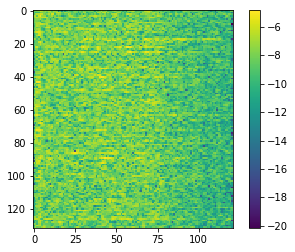

In [842]:
plt.imshow(log_specgram(s1*.001)[2], interpolation='none')
plt.colorbar()
plt.show()

In [863]:
x_mean

-3.8610516

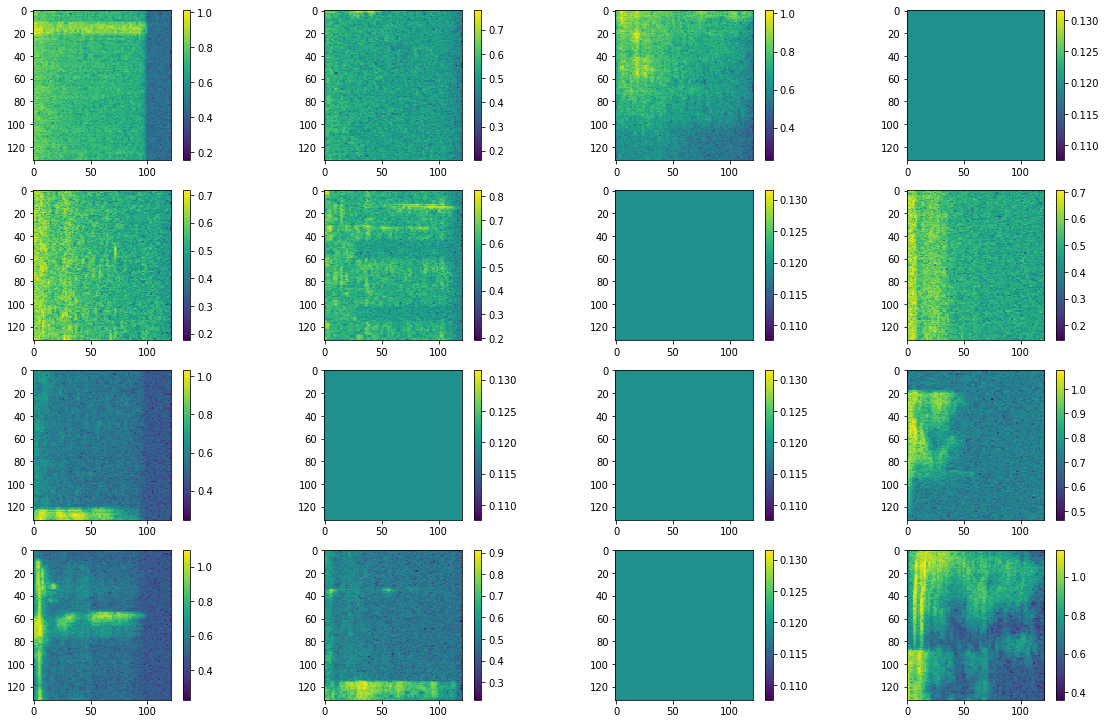

In [943]:
f = plt.figure(figsize=(20,16))
a = [0,4,5,6,7,11,12,14,17,18,20,22,24,25,26,66]
for i in range(16):
    plt.subplot(5,4,i+1) 
    plt.imshow((np.array(im[a[i]])+4)/6, interpolation='none')
    plt.colorbar()
plt.show()
f.savefig('silence_test.svg', bbox_inches='tight')

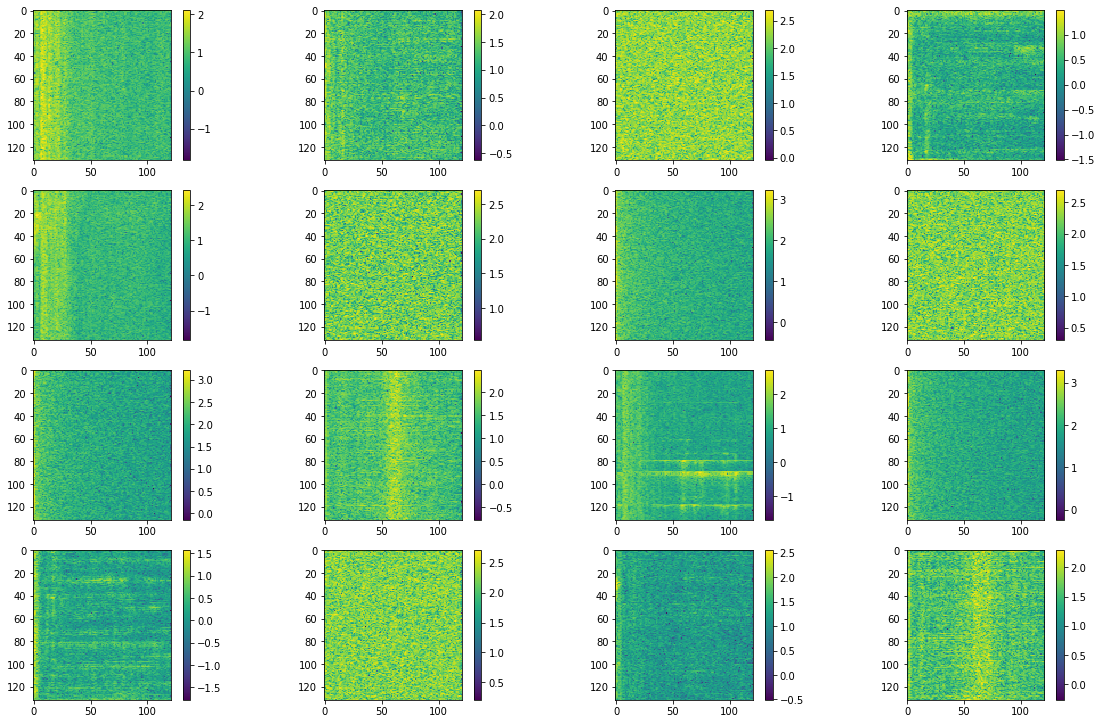

In [877]:
f = plt.figure(figsize=(20,16))
for i in range(16):
    plt.subplot(5,4,i+1) 
    plt.imshow(s[np.random.randint(324)], interpolation='none')
    plt.colorbar()
plt.show()
#f.savefig('silence_train.svg', bbox_inches='tight')

In [96]:
np.min(s1)

-4024

In [130]:
ims = []
rate, samples = wavfile.read(os.path.join('pseudo', 'on', "clip_00c4e1332.wav"))
samples = pad_audio(samples)
resampled = signal.resample(samples, int(new_sample_rate / rate * samples.shape[0]))
_, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
ims.append(specgram)

pred = model.predict((np.array(ims) - x_mean) / x_std)

In [131]:
pred[0]

array([4.5142027e-05, 2.3963228e-05, 2.6731126e-05, 2.9044217e-05,
       2.3458326e-02, 9.7553945e-01, 8.9399451e-05, 1.2088838e-06,
       4.9073034e-05, 3.2448152e-04, 4.0067796e-04, 1.2540844e-05],
      dtype=float32)

In [43]:
df = pd.DataFrame(columns=['fname', 'label'])
df['fname'] = index
df['label'] = results
df.to_csv(os.path.join(out_path, 'submission.csv'), index=False)

In [44]:
df['label'].value_counts()

unknown    73594
silence    18429
on          8447
no          7855
off         6821
left        6797
right       6318
down        6288
go          6029
yes         6018
stop        6007
up          5935
Name: label, dtype: int64